In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import time
from mpl_toolkits.axes_grid1 import make_axes_locatable
from math import pi
sys.path.insert(0, "C:\\Users\\Matt\\Desktop\\orbithunter\\")
import orbithunter as orb

# Gluing

The concept of gluing is the foundation for a long sought after ability in turbulence; namely, to use coherent structures
as building blocks for larger turbulent solutions. Any orbits can be used as building blocks in theory, but their combinations may not be *admissible*. This is a theoretical detail that is too complicated to be explained here.

The first step in the gluing is to identify the orbits that we want to glue together; for this introductory example
I'll use the "fundamental periodic orbits"; those of minimal spatiotemporal extent.

In [2]:
keys = (0,1,2)
fpos = ('space_padded/defect', 'space_padded/double_streak', 'default/wiggle')
td = orb.read_tileset('./data/tiles.h5', keys, fpos)

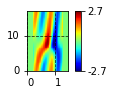

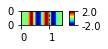

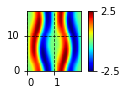

In [3]:
for k in td:
    td[k].plot()

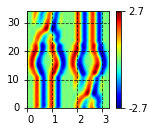

In [20]:
symbol_array = np.array([[0, 1], [2, 2], [1, 0]])
tiled_orbit = orb.tile(symbol_array, td, orb.OrbitKS, exclude_nonpositive=False).resize().transform(to='modes')
tiled_orbit.plot(padding=True)

In [22]:
tiling_result = orb.hunt(tiled_orbit.transform(to='modes').resize(), methods=('adj', 'lstsq'), maxiter=[100000, 500],
                     verbose=False, preconditioning=True, pexp=(1,4))

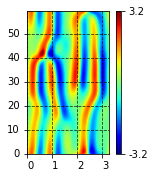

In [23]:
tiling_result.orbit.plot(padding=True)

There are many different ways to use this algorithm; fundamental (smallest) orbits can be used directly to create large
tilings, but this is not the recommended method. Why? As the number of components increases, so does the number of discontinuous boundaries, therefore the spectrum of the final result is polluted by the Gibbs phenomenon. Additionally,
if the dimensions of the tiles are significantly different enough, then the collocation grid becomes more irregular.

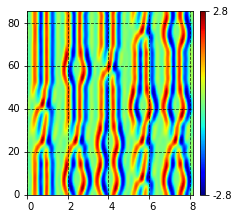

In [50]:
np.random.seed(30)
big_symbol_array = (3*np.random.rand(5, 5)).astype(int)
big_tiling = orb.tile(big_symbol_array, td, orb.OrbitKS, strip_wise=False, gluing_order=(1,0)).resize(32, 48)
big_tiling.plot(padding=True)

Also, to attempt to capture differences in dimension more accurately, the `strip_wise=True` keyword can be passed; it
glues the configuration constitutes in 1-d strips. Once again when the configuration gets too large, orbits can be distorted relative to each other.

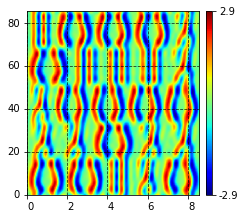

In [55]:
np.random.seed(20)
big_symbol_array = (3*np.random.rand(5, 5)).astype(int)
big_tiling = orb.tile(big_symbol_array, td, orb.OrbitKS, strip_wise=True, gluing_order=(1,0)).resize(32, 48)
big_tiling.plot(padding=True)

In [ ]:
big_tiling_result = orb.hunt(big_tiling.transform(to='modes'),
                             preconditioning=True, methods=('adj', 'lsmr'),
                             maxiter=[250000, 1000])

In [ ]:
big_tiling_result.orbit.cost()

In [ ]:
big_tiling_result.orbit.plot(padding=True)

Instead of approaching this gluing in a "single step", gluing can be applied iteratively; in other words, it can be
applied using orbits of larger size, not only fundamental orbits. Therefore, we can break the optimization into steps, alternating between `glue` and `hunt`.

In [ ]:
larger_tiles = np.array(orb.read_h5("./data/OrbitKS.h5"))[[10, 77, 60, 55]]
larger_tileset = orb.rediscretize_tileset(dict(zip(range(4), larger_tiles)), (32, 32))
for k in larger_tileset:
    larger_tileset[k].plot()

In [ ]:
np.random.seed(0)
large_symbol_array = (4*np.random.rand(5, 4)).astype(int)

large_tiling = orb.tile(large_symbol_array, larger_tileset,
                        orb.OrbitKS, stripwise=False).resize().transform(to='modes')
large_tiling.plot()

In [ ]:
large_tiling_result = orb.hunt(large_tiling, methods=('adj', 'lsmr'),
                               preconditioning=True, maxiter=[100000, 250], ftol=1e.6)
large_tiling_result.orbit.plot(padding=True)

If the combination of two specific orbits is being targeted, then the "expensive pairwise glue" function can be used. This
function searches over all pairs of all members of the group orbit of each constituent. In this example, I'll use two
orbits with discrete symmetry and then return a result with the same symmetry; this requires a special consideration
for this gluing, namely, two halves of one of the orbits must be concatenated in a "double ended queue" style instead
of simply at the end.

In [5]:
o1, o2 = orb.read_h5('./data/ShiftReflectionOrbitKS.h5', ('t93p804_x22p000','t30p451_x34p465'))
o1, o2 = o1.transform(to="field"), o2.transform(to="field")



In [7]:
ppo1, ppo2, ppo3 = [x.resize(64, 64).transform(to='field') for x in orb.read_h5("./data/ShiftReflectionOrbitKS.h5",
                    ('t20p505_x21p999', 't28p660_x21p999', 't66p708_x22p007'))]


Let's look at the three orbits to combine using orbithunter's density plots for the KSE.  

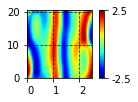

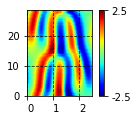

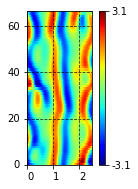

(None, None, None)

In [8]:
ppo1.plot(), ppo2.plot(), ppo3.plot()

To preserve the shift-reflection symmetry (reflect, translate by half time period), spatial gluing needs to occur
in a special way.

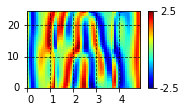

609194.1552014159


In [22]:
crude_glued = ppo2.to_fundamental_domain(half=0).concat(ppo1.to_fundamental_domain(half=0), 
                                                        axis=1).from_fundamental_domain().resize(32, 64)
crude_glued.plot()
print(f"{crude_glued.cost()}")

Looking at the gluing above, I mean, it's a gluing? I think we can do better; that is what the automated function 
`expensive_pairwise_glue` is for.

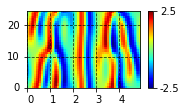

In [15]:
from orbithunter.gluing import expensive_pairwise_glue
glued = expensive_pairwise_glue(np.array([[ppo1.resize(32, 32)], [ppo2.resize(32, 32)]]),
                                orb.ShiftReflectionOrbitKS, discrete=True, axis=1,
                                fundamental_domain=True)
glued.plot()

By searching the group orbit, we have constructed an initial condition that (to my eye) doesn't appear to have any
discontinuities; compared to the last attempt it looks much better. Quantitatively, we have its cost which is 20 times smaller than the original crude attempt.

In [17]:
glued.cost()

3070.81125191018

In [24]:
result12 = orb.hunt(glued.transform(to='modes'), methods=('adj', 'lstsq'), preconditioning=True)
ppo12 = result12.orbit

Did we do well? Let's check the final cost function value, and then plot the field to ensure that a good result was
returned.

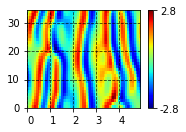

The final cost was 1.0869124153403093e-13


In [30]:
ppo12.plot()
print(f"The final cost was {ppo12.cost()}")

As previoulsy mentioned, this can be done iteratively. Let's get even bigger!

In [35]:
ppo12.transform(to='field').resize(32, 32), ppo3.transform(to='field').resize(32, 64)

(ShiftReflectionOrbitKS({"shape": [32, 32], "basis": "field", "parameters": [34.555, 44.0, 0.0]}),
 ShiftReflectionOrbitKS({"shape": [32, 64], "basis": "field", "parameters": [66.708, 22.008, 0.0]}))

Because one of the constituents is about twice as large along the spatial axis, it is rediscretized to reflect that. 

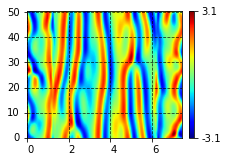

In [38]:
from orbithunter.gluing import expensive_pairwise_glue
glued = expensive_pairwise_glue(np.array([[ppo12.transform(to='field').resize(32, 64)],
                                          [ppo3.transform(to='field').resize(32, 32)]]),
                                orb.ShiftReflectionOrbitKS, discrete=True, axis=1,
                                fundamental_domain=True)
glued.plot(padding=True)

In [39]:
result123 = orb.hunt(glued.transform(to='modes'), methods=('adj', 'lstsq'), preconditioning=True)
ppo123 = result123.orbit

In [53]:
result123

   costs: [117848.79673698552, 3.52957757025518, 3.52957757025518, 2.8707727908242654e-13]
 maxiter: [10000, 500]
 message: '\nConverged. Terminating hunt with cost'
  method: ['adj', 'lstsq']
     nit: [10000, 161]
   orbit: ShiftReflectionOrbitKS({"shape": [31, 47], "basis": "modes", "parameters": [94.932, 66.008, 0.0]})
  status: 1
     tol: [1e-06, 1e-06]

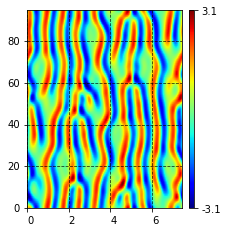

The final cost of the second gluing was 2.8707727908242654e-13


In [41]:
ppo123.plot(padding=True)
print(f"The final cost of the second gluing was {ppo123.cost()}")

I don't think I've ever found a periodic orbit as large as this with as small a residual as this using the random initialization method. Gluing presents us with an informed yet malleable initial conditions with which to search for orbits.